<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment10/Assignment_10_Adversarial_Srinath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)

# import statements

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

from matplotlib import pyplot as plt

# Change the directory

In [ ]:
working_directory = '/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/10_Assignment'
def colabDrive():
    from google.colab import drive
    drive.mount("/content/drive")

    if os.getcwd() !=  working_directory:
      os.chdir(working_directory)
    print(os.getcwd())

In [ ]:
colabDrive()

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/09_Assignment


# Prepare the data

## Fasion MNIST

4431872/4422102 [==============================] - 0s 0us/step


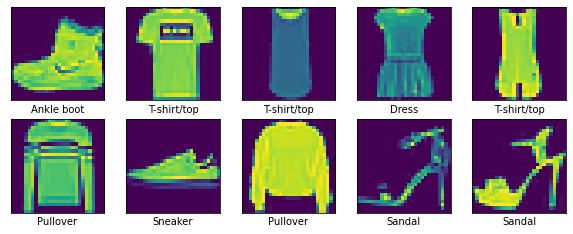

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_fasion_images, train_fasion_labels), (test_fasion_images, test_fasion_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_fasion_images[i])
    plt.xlabel(class_names[train_fasion_labels[i]])
plt.show()


train_fasion_data = tf.data.Dataset.from_tensor_slices(
    (train_fasion_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, train_fasion_labels.astype(np.int32)))
train_fasion_data = train_fasion_data.shuffle(buffer_size=60000).batch(128, drop_remainder=True)

# note: we batch the test data, but do not shuffle/repeat
test_fasion_data = tf.data.Dataset.from_tensor_slices(
    (test_fasion_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, test_fasion_labels.astype(np.int32))).batch(100)

# Observations


- Implemented Adverserial training on Fashion-MNIST
- Variation1: Creating Adversarial Examples (Only for testing)
  - Trained a model on Fashion-MNIST dataset.
  - For the test dataset created adverserial examples by wrapping in GradientTape and created adverserial examples.
    - Adverserial_Bathc = current_Image_Batch + (0.003 \* gradient)
  - For the main test data the accuracy is 92%.
  - For the adverserial test data the model performed very poor which is 40%.
- Variation2: Train Model with Adverserial Data
  - To solve the above problem occured in variation-1, now trained a model with adverserial examples.
  - Created adverserial examples for the entire train dataset, so the data became double
  - Now trained the entire model.
  - Test accueacy achieved was 90%.
  - Adverserial examples here performed better and the accuracy improved to 70%.
- Further details related to the task can be found in the below task URL.



# Generic Model, Train Loop, Test Loop

## Model

In [3]:
def _model(name="Fashion_MNIST1"):
  input_shape = (28, 28, 1)
  num_classes = 10
  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name=name,
  )
  return model

In [28]:
model_summ = _model("Summary Model MNIST")
model_summ.summary()

Model: "Summary Model MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_30 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 batch_normalization_31 (Bat  (None, 26, 26, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                               

## Model Training

In [8]:
def train_loop(model, tr_Data):
  train_steps = 2500
  EPOCHS = 5
  optimizer = tf.optimizers.Adam(learning_rate=1e-3)
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for epoch in range(EPOCHS):
    print("Epoch : ", epoch+1)
    for step, (image_batch, label_batch) in enumerate(tr_Data):

        with tf.GradientTape() as tape:
            logits = model(image_batch)
            loss = loss_fn(label_batch, logits)

        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
          
        optimizer.apply_gradients(zip(gradients, variables))
        
        train_acc_metric(label_batch, logits)
        
        if not step % 100:
            print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
            train_acc_metric.reset_states()

  return model

## Model Testing

In [5]:
def test_loop(model, test_dataset):
  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  preds = []
  for image_batch, label_batch in test_dataset:
      test_acc_metric(label_batch, model(image_batch))
      preds.append(tf.argmax(model(image_batch),axis=1,output_type=tf.int32))
  print("Test acc: {}".format(test_acc_metric.result()))
  return preds

# Model 1

## Fashion MNIST performed with normal data and adversial data used in test



1.   Normal test dataset accuracy is 92%
2.   Adverserial test dataset accuracy is 40%



In [9]:
def model_fashion_MNIST1():

  model = _model()
  # model.summary()

  #Training Progress Start
  print("Training Start")
  model = train_loop(model, train_fasion_data)
  print("Training End")
  #Training Progress End

  #Testing
  test_loop(model, test_fasion_data)
  #Testing

  return model

In [10]:
trained_model = model_fashion_MNIST1();

Training Start
Epoch :  1
Loss: 2.301668405532837 Accuracy: 0.109375
Loss: 0.4725816249847412 Accuracy: 0.6752343773841858
Loss: 0.392953485250473 Accuracy: 0.8124218583106995
Loss: 0.3564990758895874 Accuracy: 0.8456249833106995
Loss: 0.3075762987136841 Accuracy: 0.8724218606948853
Epoch :  2
Loss: 0.2888432741165161 Accuracy: 0.8810891509056091
Loss: 0.30322265625 Accuracy: 0.8864062428474426
Loss: 0.4848577380180359 Accuracy: 0.8946874737739563
Loss: 0.18503683805465698 Accuracy: 0.9008593559265137
Loss: 0.20079082250595093 Accuracy: 0.9092187285423279
Epoch :  3
Loss: 0.22852176427841187 Accuracy: 0.9125689268112183
Loss: 0.18188059329986572 Accuracy: 0.9201562404632568
Loss: 0.22586505115032196 Accuracy: 0.9140625
Loss: 0.26532506942749023 Accuracy: 0.9213281273841858
Loss: 0.22534459829330444 Accuracy: 0.9195312261581421
Epoch :  4
Loss: 0.1571120321750641 Accuracy: 0.9231387972831726
Loss: 0.19386839866638184 Accuracy: 0.9340624809265137
Loss: 0.14197342097759247 Accuracy: 0.929

## Create Adverserial Examples from test set

In [12]:
adversial_Examples = []
adversial_Labels = []
original_test_data = []
original_test_labels = []
loss_fn_test = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

for step, (image_batch, label_batch) in enumerate(test_fasion_data):
    with tf.GradientTape() as tape:
        tape.watch(image_batch)
        logits = trained_model(image_batch)
        loss = loss_fn_test(label_batch, logits)
    
    gradients = tape.gradient(loss, image_batch)

    adversial_Examples.append(tf.clip_by_value((image_batch + (0.03*(tf.math.sign(gradients)))), clip_value_min=0, clip_value_max=1))
    adversial_Labels.append(label_batch)

    original_test_data.append(image_batch)
    original_test_data.append(label_batch)

In [13]:
adv_Data = tf.data.Dataset.from_tensor_slices((adversial_Examples,adversial_Labels))

## Get Test Accuracy

In [15]:
print("Normal Test")
original_preds = test_loop(trained_model, test_fasion_data)

Normal Test
Test acc: 0.9218999743461609


In [16]:
print("Adverserial Test")
adv_Preds = test_loop(trained_model, adv_Data)

Adverserial Test
Test acc: 0.4277999997138977


## Compare the results

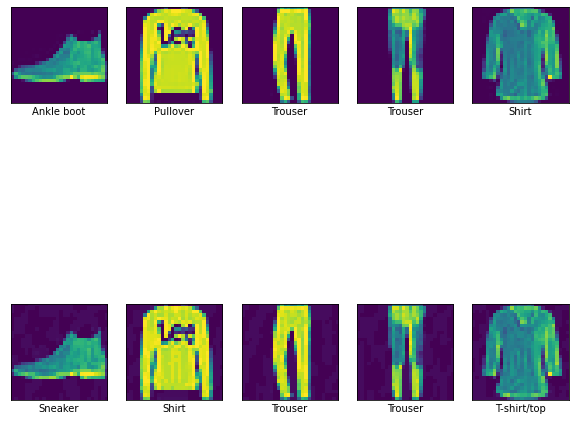

In [17]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.reshape(original_test_data[0][i], [28,28]))
    plt.xlabel(class_names[original_preds[0][i].numpy()])
    plt.subplot(2,5,i+5+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.reshape(adversial_Examples[0][i], [28,28]))
    plt.xlabel(class_names[adv_Preds[0][i].numpy()])
plt.show()

# Model 2 ( With Adverserial Data)

## Create Adverserial Data




In [21]:
adv_train_Data = []
adv_train_Labels = []
model = _model()
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
for step, (image_batch, label_batch) in enumerate(train_fasion_data):

    with tf.GradientTape() as tape:
        tape.watch(image_batch)
        logits = model(image_batch)
        loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, image_batch)

    adv_train_Data.append(image_batch)
    adv_train_Labels.append(label_batch)
      
    adv_train_Data.append(tf.clip_by_value((image_batch + (0.03*(tf.math.sign(gradients)))), clip_value_min=0, clip_value_max=1))
    adv_train_Labels.append(label_batch)

In [22]:
adv_All_Data = tf.data.Dataset.from_tensor_slices((adv_train_Data,adv_train_Labels))

## Fashion MNIST performed with normal + adverserial data during training



1.   Normal test dataset accuracy is 90%
2.   Adverserial test dataset accuracy is increased to 71%



In [23]:
def model_fashion_MNIST2():

  model = _model(name="Fashion_MNIST2")
  # model.summary()

  #Training Progress Start
  print("Training Start")
  model = train_loop(model, adv_All_Data)
  print("Training End")
  #Training Progress End

  #Testing
  test_loop(model, test_fasion_data)
  #Testing

  return model

In [24]:
trained_model_adv = model_fashion_MNIST2();

Training Start
Epoch :  1
Loss: 2.3032283782958984 Accuracy: 0.078125
Loss: 0.6146872639656067 Accuracy: 0.671093761920929
Loss: 0.50901859998703 Accuracy: 0.8041406273841858
Loss: 0.45448529720306396 Accuracy: 0.8479687571525574
Loss: 0.4593569338321686 Accuracy: 0.8517187237739563
Loss: 0.5204578638076782 Accuracy: 0.8774218559265137
Loss: 0.4893288314342499 Accuracy: 0.8776562213897705
Loss: 0.34401142597198486 Accuracy: 0.8799218535423279
Loss: 0.4629206657409668 Accuracy: 0.8863281011581421
Loss: 0.2947307229042053 Accuracy: 0.9045312404632568
Epoch :  2
Loss: 0.2556665241718292 Accuracy: 0.888671875
Loss: 0.2315060794353485 Accuracy: 0.896484375
Loss: 0.3717065453529358 Accuracy: 0.8953906297683716
Loss: 0.23169957101345062 Accuracy: 0.9078124761581421
Loss: 0.27045202255249023 Accuracy: 0.9047656059265137
Loss: 0.4424062967300415 Accuracy: 0.9146093726158142
Loss: 0.31416282057762146 Accuracy: 0.909375011920929
Loss: 0.28174495697021484 Accuracy: 0.9097656011581421
Loss: 0.31748

## Get Test Accuracy

In [25]:
print("Normal Test")
original_adv_preds = test_loop(trained_model_adv, test_fasion_data)

Normal Test
Test acc: 0.9074000120162964


In [26]:
print("Adverserial Test")
adv_adv_Preds = test_loop(trained_model_adv, adv_Data)

Adverserial Test
Test acc: 0.7196999788284302


## Compare the results

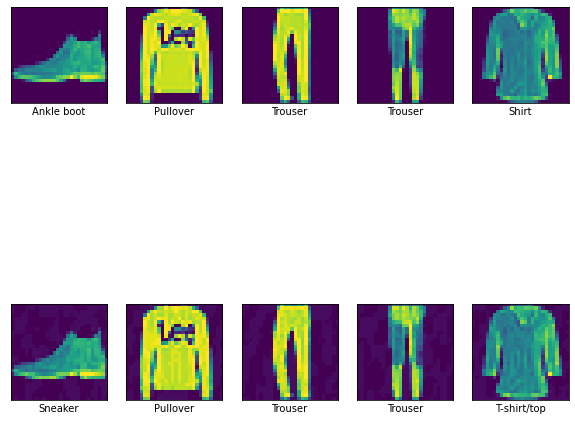

In [27]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.reshape(original_test_data[0][i], [28,28]))
    plt.xlabel(class_names[original_adv_preds[0][i].numpy()])
    plt.subplot(2,5,i+5+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.reshape(adversial_Examples[0][i], [28,28]))
    plt.xlabel(class_names[adv_adv_Preds[0][i].numpy()])
plt.show()